In [1]:
import tensortools as tt
import numpy as np
import matplotlib.pyplot as plt


In [65]:
def rank_one_tensor(a, b, c):
    """Returns a rank 1 tensor, given three vectors  
    """
    a = a.reshape(-1, 1).astype(np.float32)
    b = b.reshape(-1, 1).astype(np.float32)
    c = c.reshape(-1, 1).astype(np.float32)
    return np.tensordot(a * b.T, c, axes=0)[:, :, :, 0]

def normalize(x, lower=0, upper=1, axis=0):
    return (x - x.min(axis=axis)) / (x.max(axis=axis) - x.min(axis=axis))


def reconstruct(factors, rank=None):
    a, b, c = factors
    rank = rank if rank else a.shape[1]
    R1s = np.zeros((a.shape[0], b.shape[0], c.shape[0], rank))
    for i in range(rank):
        R1s[:, :, :, i] = rank_one_tensor(a[:, i], b[:, i], c[:, i])
    return R1s.sum(axis=3)

def plot_factors(factors, d=3):
    a, b, c = factors
    rank = a.shape[1]
    fig, axes = plt.subplots(rank, d, figsize=(8, int(rank * 1.2 + 1)))
    factors_name = ["Time", "Features", "Time"] if d==3 else ["Time", "Features"]
    for ind, (factor, axs) in enumerate(zip(factors[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()
    

In [3]:

# Make synthetic dataset.
I, J, K, R = 25, 25, 25, 4  # dimensions and rank
X = tt.randn_ktensor((I, J, K), rank=R).full()
X += np.random.randn(I, J, K)  # add noise


In [9]:
X.shape

(25, 25, 25)

In [4]:

# Fit CP tensor decomposition (two times).
U = tt.cp_als(X, rank=R, verbose=True)
V = tt.cp_als(X, rank=R, verbose=True)


CP_ALS: iteration 1, objective 0.8377024459665664, improvement inf.
CP_ALS: iteration 2, objective 0.5777255450198423, improvement 0.2599769009467241.
CP_ALS: iteration 3, objective 0.5605702441589514, improvement 0.0171553008608909.
CP_ALS: iteration 4, objective 0.5427018717678865, improvement 0.01786837239106487.
CP_ALS: iteration 5, objective 0.5312258342118145, improvement 0.011476037556072072.
CP_ALS: iteration 6, objective 0.5305447900296687, improvement 0.0006810441821457625.
CP_ALS: iteration 7, objective 0.5305405339672082, improvement 4.256062460461507e-06.
Converged after 7 iterations, 0.017973764799535275 seconds. Objective: 0.5305405339672082.
CP_ALS: iteration 1, objective 0.7053036862171618, improvement inf.
CP_ALS: iteration 2, objective 0.5935150274916212, improvement 0.11178865872554056.
CP_ALS: iteration 3, objective 0.572884379229236, improvement 0.020630648262385254.
CP_ALS: iteration 4, objective 0.5577263197368739, improvement 0.015158059492362042.
CP_ALS: itera

In [5]:
%matplotlib notebook

<IPython.core.display.Javascript object>


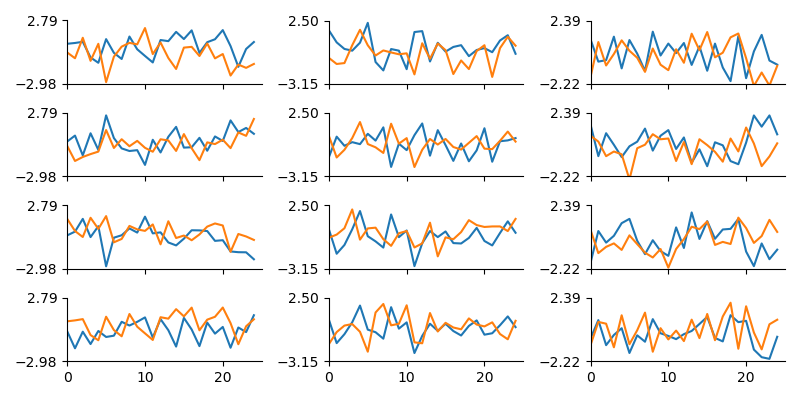

(<Figure size 800x400 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aebce2d1d90>,
       dtype=object),
 array([[list([<matplotlib.lines.Line2D object at 0x2aebcf308e50>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf308bd0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf009e10>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf34d6d0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf0b8390>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf0efb90>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf12c3d0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf2b5d50>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf1a2450>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf361ed0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf31c990>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf217450>])]],
       dtype=object))

In [6]:
# Compare the low-dimensional factors from the two fits.
fig, _, _ = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)


In [7]:

# Align the two fits and print a similarity score.
sim = tt.kruskal_align(U.factors, V.factors, permute_U=True, permute_V=True)
print(sim)


0.6869345629885653


<IPython.core.display.Javascript object>


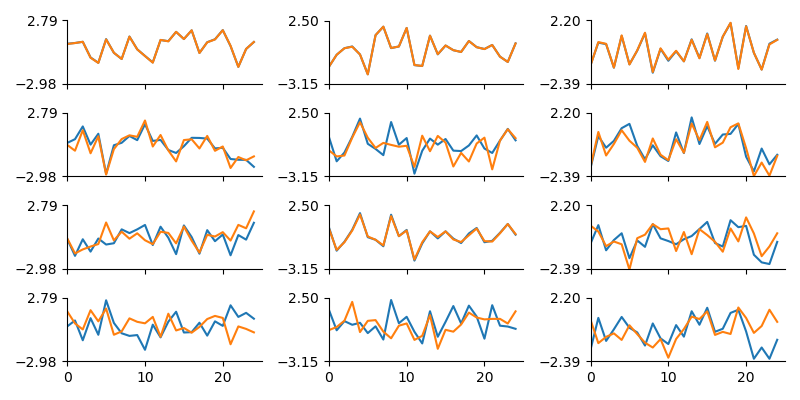

(<Figure size 800x400 with 12 Axes>,
 array([[<matplotlib.axes._subplots.AxesSubplot object at 0x2aebcf3d0c10>,
       dtype=object),
 array([[list([<matplotlib.lines.Line2D object at 0x2aebcfaeb490>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfaeb450>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf823a50>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf861290>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfb13190>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfb1aa10>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf90cad0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfb259d0>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcf983b50>])],
        [list([<matplotlib.lines.Line2D object at 0x2aebcf9c2390>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfad1c90>]),
         list([<matplotlib.lines.Line2D object at 0x2aebcfb2fed0>])]],
       dtype=object))

In [8]:
# Plot the results again to see alignment.
fig, ax, po = tt.plot_factors(U.factors)
tt.plot_factors(V.factors, fig=fig)


# Data

In [69]:
%pip install seaborn

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [189]:
import _pickle as pkl
import seaborn as sns
import copy

In [3]:
import os
import glob
import pandas as pd

In [210]:
rootdir = '/n/coxfs01/2p-data'
animalid = 'JC084'
session = '20190522'
fov = 'FOV1_zoom2p0x'
traceid = 'traces001'

experiment = 'gratings'

In [211]:
dfn = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_%s*' % experiment, 'traces', '%s*' % traceid, 'data_arrays', '*.npz'))[0]


In [212]:
dset = np.load(dfn, allow_pickle=True)
list(dset.keys())

['zscore',
 'dff',
 'ylabels',
 'corrected',
 'labels_columns',
 'sconfigs',
 'run_info',
 'meanstim',
 'labels_data']

In [213]:
traces = pd.DataFrame(dset['dff'][:])
print(traces.shape)
labels = pd.DataFrame(data=dset['labels_data'], columns=dset['labels_columns'])
print(labels.shape)
#labels.columns = [str(c) for c in labels.columns.tolist()]

(110360, 260)
(110360, 6)


In [214]:
def process_traces(raw_traces, labels, response_type='dff'):

    stim_on_frame = labels[b'stim_on_frame'].unique()[0]
    tmp_df = []
    for k, g in labels.groupby([b'trial']):
        tmat = raw_traces.loc[g.index]
        bas_mean = np.nanmean(tmat[0:stim_on_frame], axis=0)
        if response_type == 'dff':
            tmat_df = (tmat - bas_mean) / bas_mean
        elif response_type == 'zscore':
            bas_std = np.nanstd(tmat[0:stim_on_frame], axis=0)
            tmat_df = (tmat - bas_mean) / bas_std
        tmp_df.append(tmat_df)
    processed_traces = pd.concat(tmp_df, axis=0)
    
    return processed_traces


In [215]:
#traces = process_traces(traces, labels)

In [384]:
outdir

NameError: name 'outdir' is not defined

# Get responsive cells only

In [315]:
responsive_test = 'nstds'
responsive_thr = 10.
n_stds = 2.5

stats_fpath = glob.glob(os.path.join(rootdir, animalid, session, fov, 'combined_%s*' % experiment, 
                                    'traces', '%s*' % traceid, 'summary_stats', responsive_test, '*.pkl'))[0]
with open(stats_fpath, 'rb') as f:
    rstats = pkl.load(f, fix_imports=True, encoding='latin1')


In [316]:
if responsive_test == 'ROC':
    roi_list = [r for r, res in rstats.items() if res['pval'] < responsive_thr]
    nrois_total = len(rstats.keys())
elif responsive_test == 'nstds':
    assert n_stds == rstats['nstds'], "... incorrect nstds, need to recalculate"
    roi_list = [r for r in rstats['nframes_above'].columns if any(rstats['nframes_above'][r] > responsive_thr)]
    nrois_total = rstats['nframes_above'].shape[-1]
print("%i out of %i cells responsive." % (len(roi_list), nrois_total))

127 out of 260 cells responsive.


In [340]:
from statsmodels.nonparametric.smoothers_lowess import lowess
def smooth_traces(trace, frac=0.002):
    missing='none'
    '''
    lowess algo (from docs):

    Suppose the input data has N points. The algorithm works by estimating the
    smooth y_i by taking the frac*N closest points to (x_i,y_i) based on their
    x values and estimating y_i using a weighted linear regression. The weight
    for (x_j,y_j) is tricube function applied to abs(x_i-x_j).

    Set 'missing' to 'drop' to ignore NaNs. Set 'return_sorted' to False to
    return array of the same sequence as input (doesn't omit NaNs)
    '''
    xvals = np.arange(len(trace))
    filtered = lowess(trace, xvals, is_sorted=True, frac=frac, it=0, missing=missing, return_sorted=False)
    if len(filtered.shape) > 1:
        return filtered[:, 1]
    else:
        return filtered



In [351]:
tr = traces[roi_list]


In [352]:
frac = 0.003

if smooth:
    tr = tr.apply(smooth_traces, frac=frac) #axis=0)


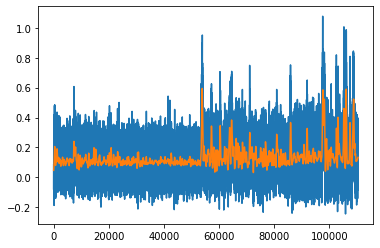

In [354]:
plt.figure()
plt.plot(traces[12])
plt.plot(tr[12])


In [370]:
tdf = np.dstack([traces[roi_list].loc[g.index.tolist()].T for k, g in labels.groupby([b'trial']) \
                if len(np.where(np.isnan(traces.loc[g.index.tolist()].T))[0])==0])
print(tdf.shape)

(127, 89, 1240)


In [371]:
trial_list = [k for k, g in labels.groupby([b'trial']) if len(np.where(np.isnan(traces.loc[g.index.tolist()].T))[0])==0]
len(trial_list)

1240

In [391]:
X = tdf.copy()
X.shape
rank=16

In [392]:
#%pip install statsmodels

In [393]:
X.shape

(127, 89, 1240)

In [ ]:
# Perform CP decomposition using tensortools
U = tt.cp_als(X, rank=rank, verbose=False)
factors_tt = U.factors.factors

In [ ]:
# Reconstruct M, with the result of each library
M_tt = reconstruct(factors_tt)

In [ ]:
# Compute the reconstruction error
rec_error_tt = np.mean((X-M_tt)**2)
print(rec_error_tt)

In [ ]:
factors_tt[0].shape

In [ ]:
# plot the decomposed factors from TensorLy
#plot_factors(factors_tt, d=3)
#plt.suptitle("Factors computed with tensortool", y=1.1, fontsize=20);

In [ ]:
a, b, c = factors_tt
rank = a.shape[1]
print("rank: %i" % rank)


In [ ]:
sdf = pd.DataFrame(dset['sconfigs'][()]).T.sort_index()
if experiment == 'blobs':
    sizes = sorted([round(i) for i in sdf['size'].unique() if i is not None])
    morphs = sorted([round(i) for i in sdf['morphlevel'].unique()])

    control_ixs = sdf[sdf['color']!=''].index.tolist()
    sdf.loc[control_ixs, 'size'] = sizes
    sdf['size'] = [round(i) for i in sdf['size'].values]


In [ ]:
experiment

In [ ]:
outdir = os.path.join('/n/coxfs01/julianarhee/aggregate-visual-areas/tensors')
if not os.path.exists(outdir):
    os.makedirs(outdir)
print(outdir)

In [ ]:
for color_by in ['sf', 'speed', 'size', 'ori']:
    #color_by = 'sf' # 14?
    #color_by = 'speed' #9?
    #color_by = 'size'
    #color_by = 'ori'

    #assert color_by in sdf.columns.tolist(), "Parameter not found: %s" % color_by
    if experiment == 'blobs':
        if color_by == 'size':
            cvalues = copy.copy(sizes)
        else:
            cvalues = copy.copy(morphs)
    elif experiment == 'gratings':
        cvalues = copy.copy(sorted(sdf[color_by].unique()))

    ccolor = sns.color_palette('cubehelix', n_colors=len(cvalues))
    colordict = dict((sz, col) for sz, col in zip(cvalues, ccolor))

    config_in_trial = [g[b'config'].values[0] for k, g in labels[labels[b'trial'].isin(trial_list)].groupby([b'trial'])]


    color_array = [colordict[sdf[color_by][c]] for c in config_in_trial]
    len(color_array)

    # Plot -----------------------------------------
    d=3
    fig, axes = plt.subplots(rank, d,  figsize=(15, int(rank * 2 + 1)))
    factors_name = ["Neurons", "Time (frames)", "Trials"] 
    for ind, (factor, axs) in enumerate(zip(factors_tt[:d], axes.T)):
        axs[-1].set_xlabel(factors_name[ind])
        for i, (f, ax) in enumerate(zip(factor.T, axs)):
            sns.despine(top=True, ax=ax)
            if ind == (d-1):
                if color_by == 'speed':
                    midp = int(round(len(f)/2.))
                    ax.scatter(np.arange(0, midp), f[0:midp], s=5, c=color_array[0:midp])
                    ax.scatter(np.arange(0, len(f[midp:])), f[midp:], s=5, c=color_array[midp:])
                else:
                    ax.scatter(np.arange(0, len(f)), f, s=5, c=color_array)
            elif ind == 0:
                ax.bar(list(range(len(f))), f, width=1, alpha=0.5, linewidth=2)
            else:
                ax.plot(f)
            axes[i, 0].set_ylabel("Factor " + str(i+1))
    fig.tight_layout()

    skey = '-'.join([animalid, session, fov])

    plt.savefig(os.path.join(outdir, '%s_rank-%i_tensor-decomp_%s__%s.png' % (experiment, rank, color_by, skey)))
    #plt.close()

<BarContainer object of 260 artists>

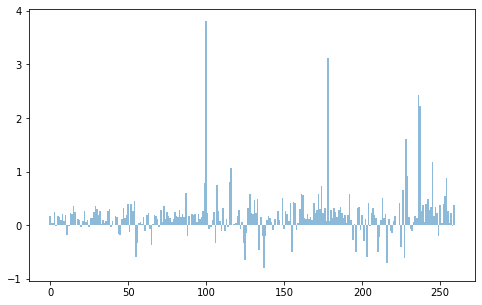

In [148]:
plt.figure(figsize=(8,5))
plt.bar(list(range(len(f))), f, width=1, alpha=0.5, linewidth=2)

In [136]:
np.linspace(0, 5*10, 5)

array([ 0. , 12.5, 25. , 37.5, 50. ])